# Improting Data

In [1]:
#Import necessary files
import tensorflow as tf
import pandas as pd
from tensorflow import keras

In [2]:
#import drive to import data from
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**What is the dataset used ? Content of the dataset ?**<br>
The dataset used is the IMDb movie review dataset. It has 50000 movie reviews labeled as positive or negative. This dataset is used to make a model that classifies these reviews as positive or negative.




In [3]:
data_path = "/content/drive/MyDrive/IMDB Dataset.csv"
data = pd.read_csv(data_path)

In [4]:
data.shape

(50000, 2)

In [5]:
#Equal instances of both the classes.
print(data['sentiment'].value_counts())

positive    25000
negative    25000
Name: sentiment, dtype: int64


# Creating preprocessing pipeline

In [6]:
#Convert labels to numbers
mapping = {'positive':1, 'negative':0}
data['sentiment'] = data['sentiment'].map(mapping)

In [7]:
data.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [8]:
from sklearn.model_selection import train_test_split 

In [9]:
#Split data into train and test sets. 
#The test set is stratified.
xtrain_set, xtest, ytrain_set, ytest = train_test_split(data['review'], data['sentiment'], random_state=42, stratify=data['sentiment'], test_size = 0.2)

In [10]:
print(xtrain_set.shape, ytrain_set.shape)

(40000,) (40000,)


In [11]:
# create train and validation data
xtrain, ytrain = xtrain_set[:30000], ytrain_set[:30000]
xval, yval = xtrain_set[30000:40001], ytrain_set[30000:40001]

In [12]:
max_vocab = 20000 #Create a limit for max words in the vocablary
tokenizer = keras.preprocessing.text.Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(xtrain)

In [13]:
#Size of the vacablary
V = len(tokenizer.word_index)
print("Size of vocab:",V)

Size of vocab: 98497


In [14]:
def preprocess_pipeline(data_, max_padding=None):
  data_ = tokenizer.texts_to_sequences(data_)
  data_ = keras.preprocessing.sequence.pad_sequences(data_, maxlen=max_padding)
  return data_

In [15]:
tokenised_xtrain = preprocess_pipeline(xtrain)
print(tokenised_xtrain.shape)

(30000, 2323)


In [16]:
T = tokenised_xtrain.shape[1]

In [17]:
tokenised_xval = preprocess_pipeline(xval, T)

In [18]:
tokenised_xtest = preprocess_pipeline(xtest, T)

In [19]:
ytrain, yval, ytest = ytrain.values, yval.values, ytest.values

In [20]:
#Create a callback to be used by models
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

**What is the model preferred to do classification ? Why was it chosen ? What are other alternatives ?**<br>
The chosen model is a neural network.
Neural networks are was chosen because they are capable of capturing complex patterns within the data, especially if the data has a lot of features.<br>
Other alternatives for classification are Logistic Regression, Support Vector Machines, Decision Trees, K-Nearest Neighbours etc.

# 1-D Convolutional model

In [21]:
#1d_convolutional model
D = 128

input_ = keras.layers.Input(shape=(T,))
embed = keras.layers.Embedding(V + 1, D)(input_)

conv_1 = keras.layers.Conv1D(32, 3, activation='relu')(embed)
pool_1 = keras.layers.MaxPooling1D(3)(conv_1)

conv_2 = keras.layers.Conv1D(128, 3, activation='relu')(pool_1)
pool_2 = keras.layers.MaxPooling1D(3)(conv_2)

conv_3 = keras.layers.Conv1D(128, 3, activation='relu')(pool_2)
gpool = keras.layers.GlobalMaxPooling1D()(conv_3)

output = keras.layers.Dense(1, activation='sigmoid')(gpool)

conv_model = keras.models.Model(inputs=[input_], outputs=[output])

In [22]:
conv_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2323)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2323, 128)         12607744  
_________________________________________________________________
conv1d (Conv1D)              (None, 2321, 32)          12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 773, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 771, 128)          12416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 257, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 255, 128)          49280 

In [23]:
conv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
#Save initial weights in case we need to revert back
conv_model_weights = conv_model.get_weights()

In [25]:
batchsize = 64
conv_model_hist = conv_model.fit(tokenised_xtrain, ytrain, validation_data=(tokenised_xval, yval), epochs=500, callbacks=[early_stop], batch_size=batchsize)

Epoch 1/500
469/469 [==============================] - 83s 163ms/step - loss: 0.5505 - accuracy: 0.6614 - val_loss: 0.2869 - val_accuracy: 0.8792
Epoch 2/500
469/469 [==============================] - 75s 159ms/step - loss: 0.1884 - accuracy: 0.9326 - val_loss: 0.2859 - val_accuracy: 0.8845
Epoch 3/500
469/469 [==============================] - 74s 159ms/step - loss: 0.0775 - accuracy: 0.9760 - val_loss: 0.4177 - val_accuracy: 0.8649
Epoch 4/500
469/469 [==============================] - 74s 157ms/step - loss: 0.0227 - accuracy: 0.9949 - val_loss: 0.5240 - val_accuracy: 0.8728
Epoch 5/500
469/469 [==============================] - 72s 154ms/step - loss: 0.0080 - accuracy: 0.9981 - val_loss: 0.6484 - val_accuracy: 0.8752
Epoch 6/500
469/469 [==============================] - 72s 154ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.7789 - val_accuracy: 0.8657
Epoch 7/500
469/469 [==============================] - 72s 154ms/step - loss: 0.0227 - accuracy: 0.9915 - val_loss: 0.7202 -

In [26]:
conv_model.evaluate(tokenised_xtest, ytest)

313/313 [==============================] - 3s 10ms/step - loss: 0.2771 - accuracy: 0.8855


[0.27713796496391296, 0.8855000138282776]

# RNN MODEL

In [27]:
D = 128

i = keras.layers.Input(shape=(T,))
embedding = keras.layers.Embedding(V+1, D)(i)
gru_1 = keras.layers.GRU(128, return_sequences=True)(embedding)
gru_2 = keras.layers.GRU(128)(gru_1)
o = keras.layers.Dense(1, activation='sigmoid')(gru_2)
rnn_model = keras.models.Model(inputs=[i], outputs=[o])



In [28]:
rnn_model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])

In [30]:
rnn_model_history = rnn_model.fit(tokenised_xtrain, ytrain, validation_data=(tokenised_xval, yval), epochs=500, callbacks=[early_stop], batch_size=64)

Epoch 1/500
469/469 [==============================] - 168s 359ms/step - loss: 0.4373 - accuracy: 0.7975 - val_loss: 0.3030 - val_accuracy: 0.8757
Epoch 2/500
469/469 [==============================] - 168s 358ms/step - loss: 0.2360 - accuracy: 0.9103 - val_loss: 0.2863 - val_accuracy: 0.8820
Epoch 3/500
469/469 [==============================] - 168s 358ms/step - loss: 0.1879 - accuracy: 0.9299 - val_loss: 0.3186 - val_accuracy: 0.8646
Epoch 4/500
469/469 [==============================] - 167s 357ms/step - loss: 0.1020 - accuracy: 0.9652 - val_loss: 0.3573 - val_accuracy: 0.8751
Epoch 5/500
469/469 [==============================] - 168s 358ms/step - loss: 0.0536 - accuracy: 0.9838 - val_loss: 0.4322 - val_accuracy: 0.8775
Epoch 6/500
469/469 [==============================] - 168s 358ms/step - loss: 0.0415 - accuracy: 0.9871 - val_loss: 0.4242 - val_accuracy: 0.8669
Epoch 7/500
469/469 [==============================] - 168s 359ms/step - loss: 0.0248 - accuracy: 0.9928 - val_loss: 0

In [31]:
rnn_model.evaluate(tokenised_xtest, ytest)

313/313 [==============================] - 24s 77ms/step - loss: 0.2827 - accuracy: 0.8852


[0.2827081084251404, 0.885200023651123]

**What are the metrics used to evaluate model classification ? Quantatively explain the preformance of the model.**<br>
The metric used to evaluate the model is accuracy. Other metric is the F1 score which is used when the data has skewed classes.<br>
The convolution model preformed same as the RNN model, the models have 88.5% accuracy on the test data which means they correctly classified almost 89 % of the reviews that they had never seen before.

# Performance Curves 

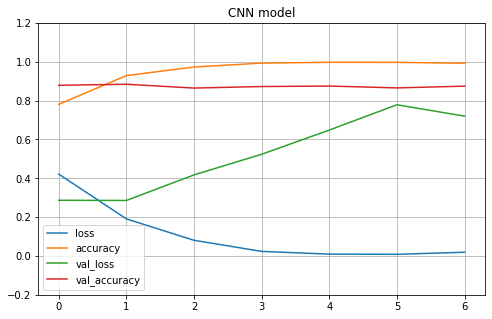

In [62]:
import matplotlib.pyplot as plt
% matplotlib inline
pd.DataFrame(conv_model_hist.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('CNN model')
plt.gca().set_ylim(-0.2,1.2)
plt.show()

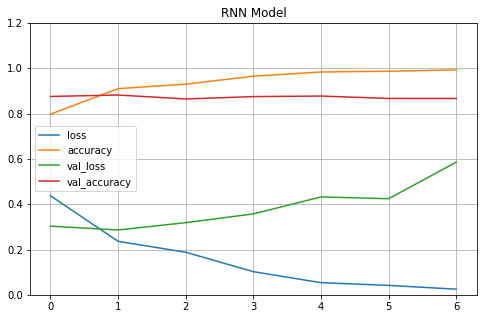

In [63]:
pd.DataFrame(rnn_model_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('RNN Model')
plt.gca().set_ylim(0,1.2)
plt.show()

#Improving Further

**How can the model be improved further ?**<br>
1) Any given model can always be improved by gathering more training data.<br>
2) We may improve preformance by removing stop words from the data.<br>
3) Try using pre-trained embeddings like the Word2Vec developed by google.<br>
4) Use transformer mechanism so the inputs can be of arbitary size and we dont have to pad the input sequences.

In [38]:
import numpy as np

In [55]:
#Print out the errors made by the model.
#This may provide insights on how to further improve the model.
def get_incorrect_indexes(model_, dataset_, index):
  ptest = model_.predict(dataset_)
  ptest = [1 if x > 0.5 else 0 for x in ptest.reshape(10000,)]
  incorrects = np.where(ptest != ytest)[0]
  return (incorrects, ptest)

In [56]:
conv_incorrects, conv_predictions = get_incorrect_indexes(conv_model, tokenised_xtest, 8)

In [57]:
def print_errors(index, ptest):
  print(xtest.iloc[incorrects[index]]) 
  print('Actual Value:',ytest[incorrects[index]], '   Predicted Value:',ptest[incorrects[index]])

In [59]:
print_errors(46, conv_predictions)

This is a decent effort for a B-Movie Martial Arts actioner. Ian Jacklin, a former North American cruiser weight Kickboxing champion, is the lead and acquits himself well in the action scenes. The muscular Matthias Hues gets a chance to add more to his Martial Arts bad guy persona in this film than in all of his many others and if you are a fan of The Teutonic Titan, rent this movie now!<br /><br />Renee Griffin is also noteworthy as the romantic interest in this film. She starts off with attitude but soon warms up to the hero and they make "The beast with two backs" in a very stylish fashion.<br /><br />The fight scenes are good in the American tradition (NO Hong Kong acrobatics here!) with added realism from having Benny "The Jet" Urquidez playing himself as John Larson's (Jacklin) trainer.<br /><br />All in all this film seems to have more sub plots than most in its genre so you get MORE of a story.
Actual Value: 1    Predicted Value: 0
